In [9]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as scp
from scipy.spatial import Voronoi, voronoi_plot_2d
from scipy.interpolate import interp2d, LinearNDInterpolator
import randomlatticethermalized as rlt
import movies_from_plots as mfp
import selfpropelledparticlevoronoi as sppv
import pathlib
from scipy import ndimage as nd 
import h5py as h5
import importlib
import findconnections as fc

In [10]:
import topologicaltransitions as tpt
import weightedgraphanalysis as wga

In [11]:
importlib.reload(mfp)
importlib.reload(sppv)
importlib.reload(rlt)
importlib.reload(tpt)
importlib.reload(wga)

<module 'weightedgraphanalysis' from '/home/rafael/Documents/tissuemodelling/SpringNetworkSimul/weightedgraphanalysis.py'>

# Making a network

In [92]:
N = 5**2
L_max = 5
L_min = -5

x_coord = (L_max-L_min)*(np.random.rand(N)) + L_min
y_coord = (L_max-L_min)*(np.random.rand(N)) + L_min

coords = np.array((x_coord,y_coord)).T

In [91]:
N_m = 15
L_max = 5
L_min = -5  
dL = (L_max-L_min)/N_m
A_0 = np.array([[1,0],[-1/2,np.sqrt(3)/2]])
#A_0 = np.eye(2)
A = 1/(2*np.linalg.det(A_0))*(A_0.T+A_0)
A_inv = np.linalg.inv(A)

LxyM = A_inv.dot(np.array([L_max,L_max]))
Lxym = A_inv.dot(np.array([L_min,L_min]))

u = np.linspace(Lxym[0],LxyM[0],N_m)
v = np.linspace(Lxym[1],LxyM[1],N_m)

coord_list = []

for j in range(N_m):
    for i in range(N_m):
        coord_list.append(A.dot(np.array([u[j],v[i]])))
        
coords = np.array(coord_list)

N = N_m**2

# Reciprocal network

In [ ]:
xy_hist = np.histogram2d(coords[:,0],coords[:,1],bins=200)
fft_hist = np.fft.fft2(nd.gaussian_filter(xy_hist[0],0))

dx = dL*N_m/200

freq = np.linspace(0,1,100)/(2*dx)
fft_x = np.mean(np.abs(np.fft.fftshift(fft_hist)),axis=1)
fft_y = np.mean(np.abs(np.fft.fftshift(fft_hist)),axis=0)

In [ ]:
#plt.pcolormesh(xy_hist[1],xy_hist[2],nd.gaussian_filter(xy_hist[0],1))
plt.pcolormesh(xy_hist[1],xy_hist[2],np.abs(np.fft.fftshift(fft_hist)))
#plt.plot(coords[:,0],coords[:,1],'.')

In [ ]:
plt.plot(freq[:],(fft_x-0*nd.gaussian_filter(fft_x,1))[100:])
#plt.plot((fft_y-nd.gaussian_filter(fft_y,0.4))[100:])

# Visualizing a network

In [6]:
DeltaL = L_max - L_min
r0 = DeltaL/(3*np.sqrt(N))

#Model parameters
K_run = 0.3
A0_run = np.pi*r0**2
G_run = 1
L_run = -1

In [7]:
vorVertices[0]

array([-2.5, -2.5])

In [8]:
def F_vertex(K,A0,G,L,vu,vb,va,A,P):
    z = np.array([0,0,1])
    
    nA = np.cross(z,va-vb)[:-1]
    
    rua = vu - va
    rbu = vb - vu
    nua = rua/sppv.norm(rua)
    nbu = rbu/sppv.norm(rbu)
    nP = nua - nbu
    
    F = -K/2*(A-A0)*nA - (G*P+L)*nP
    return F

def F_square(K,A0,G,L,A,P):
    v_array = np.array([[-2.5, -2.5],
       [ 2.5, -2.5],[2.5, 2.5],[-2.5,  2.5]])
    F_v = []
    for i in range(4):
        vu = v_array[i]
        va = v_array[(i-1)%4]
        vb = v_array[(i+1)%4]
        F_v.append(F_vertex(K,A0,G,L,vu,vb,va,A,P))
    return np.array(F_v)
    

In [9]:
dx_list = 10**(np.linspace(-15,0.5,100))


In [10]:
F_vertex1 = F_square(K_run,A0_run, G_run, L_run, 25, 20)
F_vertex2 = sppv.force_vtx_elastic(vorRegions, vorPointRegion, vorRidges, K_run,A0_run,G_run,L_run,vorVertices,coords,1e-6)

In [11]:
print(F_vertex1.round(4))
print(F_vertex2.round(4))

[[ 34.8411  34.8411]
 [-34.8411  34.8411]
 [-34.8411 -34.8411]
 [ 34.8411 -34.8411]]
[[ 34.8411  34.8411]
 [-34.8411  34.8411]
 [ 34.8411 -34.8411]
 [-34.8411 -34.8411]]


In [12]:
FV1 = []
FV2 = []
F_vertex1 = F_square(K_run,A0_run, G_run, L_run, 25, 20)
for dx in dx_list:
        vor = Voronoi(coords)
        vorPointRegion = vor.point_region
        vorRegions = vor.regions
        vorRidges = sppv.remove_minus(vor.ridge_vertices)
        vorVertices = np.array(vor.vertices)
        
        
        F_vertex2 = sppv.force_vtx_elastic(vorRegions, vorPointRegion, vorRidges, K_run,A0_run,G_run,L_run,vorVertices,coords,dx)
        
        
        err1 = np.zeros((len(F_vertex1),2))

        for i in range(len(F_vertex1)):
                err1[i] = np.abs(F_vertex2[i]-F_vertex1[i])/np.abs(F_vertex1[i])
                #err1[i,1] = np.abs(F_vertex2[i,1]-F_vertex1[i,1])/np.abs(F_vertex1[i,1])
                #np.abs(np.inner(F_vertex2[i],F_vertex1[i])/np.inner(F_vertex1[i],F_vertex1[i]))
                #err1_abs = np.zeros((len(err1),))
        

        FV1.append(np.median(err1[:2],0))

     
        

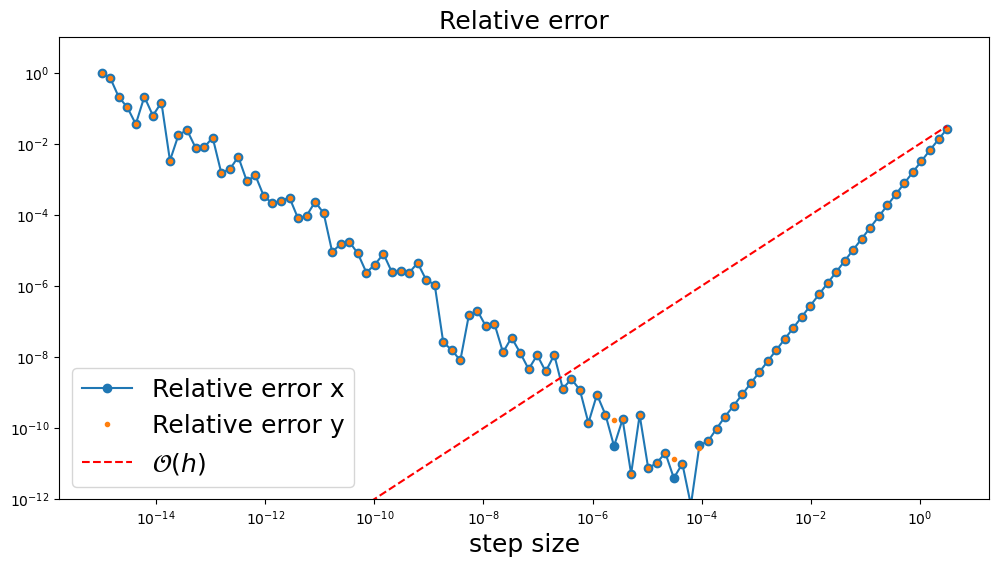

In [13]:
plt.figure(figsize=(12,6))
plt.plot(dx_list,np.array(FV1)[:,0],'-o')
plt.plot(dx_list,np.array(FV1)[:,1],'.')
#plt.plot(dx_list,FV2)
plt.plot(dx_list,1e-2*dx_list,'r--')
#plt.plot(dx_list,dx_list**0,'k--')
#plt.plot(dx_list,2+dx_list**2,'g--')
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-12,10)
plt.title("Relative error", fontsize = 18)
plt.xlabel("step size", fontsize= 18)
plt.legend(["Relative error x","Relative error y","$\mathcal{O}(h)$"], fontsize = 18)

dx

In [454]:
N

array(81)

<BarContainer object of 418 artists>

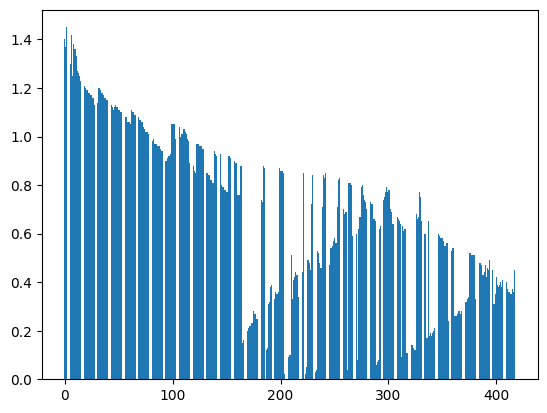

In [32]:
plt.bar(np.arange(0,len(vorVertices)),np.abs(np.linalg.eig(wga.weight_matrix(vorVertices,vorRidges))[0].round(2)))

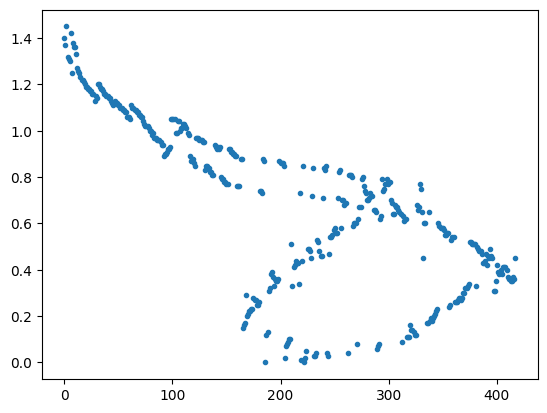

In [33]:
plt.plot(np.arange(0,len(vorVertices)),np.abs(np.linalg.eig(wga.weight_matrix(vorVertices,vorRidges))[0].round(2)),'.')

In [34]:
G = wga.adjacency_matrix(len(vorVertices),vorRidges).round(4)


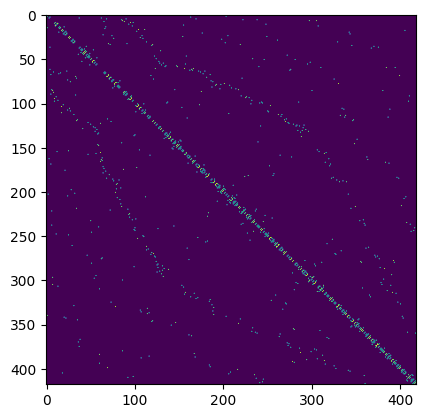

In [35]:
plt.imshow(G)

In [149]:
import findconnections as fc

# Testing topological transition

In [336]:
R1 = [1,2,3,4,5]
R2 = [2,3,6,7,8]
R3 = [3,4,7,9,10]
R4 = [1,2,6,11,12]

regions = [R1,R2,R3,R4]
point_regions = [0,1,2,3]

vertices_neigh_min = list((set(R1).intersection(R2)).union(set(R1).intersection(R3)).union(set(R3).intersection(R2)))
vertices_neigh = list((set(R1).intersection(R2)).union(set(R1).intersection(R4)).union(set(R4).intersection(R2)))


In [357]:
Ridges = [[1,2],[2,3],[3,4],[1,5],[5,4],[4,9],[9,10],[7,10],[7,8],[6,8],[6,12],[11,12],[1,11],[3,7],[2,6]]

In [1]:
import networkx as nx

In [359]:
G = nx.Graph()
G.add_edges_from(Ridges)

In [360]:
list(G.edges([2]))

[(2, 1), (2, 3), (2, 6)]

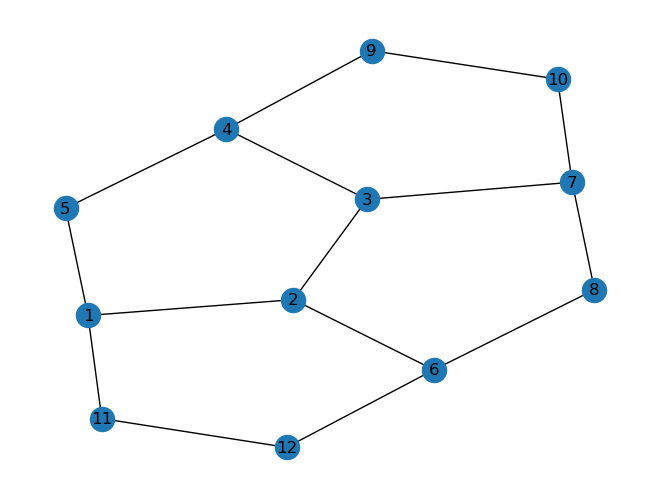

In [446]:
nx.draw(G, with_labels = True,pos = nx.spring_layout(G),)

In [337]:
print(vertices_neigh_min)
print(vertices_neigh)

[2, 3, 4, 7]
[1, 2, 3, 6]


In [338]:
#For vertex i
regions_neigh_v, center = fc.find_vertex_neighbour_centers(regions,point_regions,2)
                                
#For neighbouring vertex v_min
regions_neigh_vmin, center = fc.find_vertex_neighbour_centers(regions,point_regions,3)


In [339]:
region_common = list(set(regions_neigh_v).intersection(regions_neigh_vmin))
                        
region_exc_v = list(set(regions_neigh_v).difference(region_common))
                
region_exc_vmin = list(set(regions_neigh_vmin).difference(region_common))

In [340]:
region_exc_vmin[0]

2

In [341]:
new_region_common = list(set(region_exc_v).union(region_exc_vmin))
p_1 = np.random.rand()
i_v = 0
i_min = 1
if p_1 < 0.5:
    i_v = 1
    i_min = 0

In [342]:
#New exclusive regions for i and v_min
new_region_exc_v = region_common[i_v]   
new_region_exc_min = region_common[i_min]

In [343]:
new_region_v = list(set(new_region_common).union([new_region_exc_v]))      
new_region_vmin = list(set(new_region_common).union([new_region_exc_min]))

In [344]:
regions[region_exc_v[0]].append(3)
regions[region_exc_vmin[0]].append(2)
                            
                        
regions[new_region_exc_v].remove(3)
regions[new_region_exc_min].remove(2)
                        
edge_common_v = list(set(regions[new_region_common[0]]).intersection(regions[new_region_common[1]]))

new_neighv = list(set(regions[new_region_exc_v]).intersection(regions[region_exc_vmin[0]]).difference(set(edge_common_v).intersection(regions[new_region_exc_v])))
new_neighvm = list(set(regions[region_exc_v[0]]).intersection(regions[new_region_exc_min]).difference(set(edge_common_v).intersection(regions[new_region_exc_min])))

In [345]:
print(new_neighv)
print(new_neighvm)

[4]
[6]


In [421]:
vertices_neigh_min = list(set(vertices_neigh_min).difference(new_neighv).union(new_neighvm))
vertices_neigh = list(set(vertices_neigh).difference(new_neighvm).union(new_neighv))

In [422]:
print(vertices_neigh_min)
print(vertices_neigh)

[2, 3, 6, 7]
[1, 2, 3, 4]


In [423]:
newRidges = np.array(Ridges)

In [424]:
loc_ridges = np.where(newRidges == 2)[0]
loc_neigh_not_vm = np.where(np.array(vertices_neigh)!=3)[0]
skip_parameter = int(0)
print(vertices_neigh)
for j in range(len(loc_ridges)):   
    if 3 in newRidges[loc_ridges[j]]:
        skip_parameter += int(1)
        continue
    else:
        js = int(j+skip_parameter)
        newRidges[loc_ridges[j]]= [vertices_neigh[loc_neigh_not_vm[j]],2]  



[1, 2, 3, 4]


In [425]:
newRidges[loc_ridges]

array([[1, 2],
       [2, 3],
       [4, 2]])

In [407]:

    
#print(loc_ridges)
            

loc_ridges = np.where(newRidges == 3)[0]        
loc_neigh_not_i = np.where(np.array(vertices_neigh_min)!= 2)[0]
#print((len(loc_ridges),len(loc_neigh_not_i),len(vertices_neigh_min)))
            
skip_parameter = int(0)
                        
for j in range(len(loc_ridges)):
    if 2 in newRidges[loc_ridges[j]]:
        skip_parameter+=int(1)
        continue
    else:
        js = int(j-skip_parameter)
        newRidges[loc_ridges[j]]= [vertices_neigh_min[loc_neigh_not_i[j]],3]

In [410]:
Gnew = nx.Graph()
Gnew.add_edges_from(newRidges)

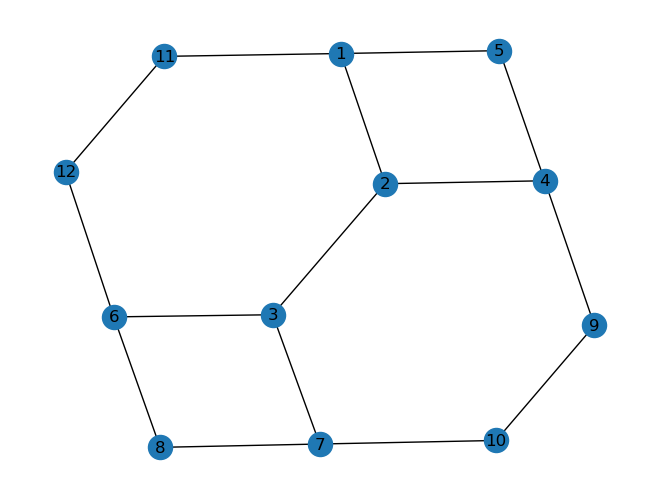

In [447]:
nx.draw(Gnew, with_labels = True,pos = nx.spring_layout(Gnew))
#nx.draw(G, with_labels = True)